# GSS 2016 Administrators, Corruption, and Political Party Analysis

In [1]:
# Import the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 2016: Less Regulation?

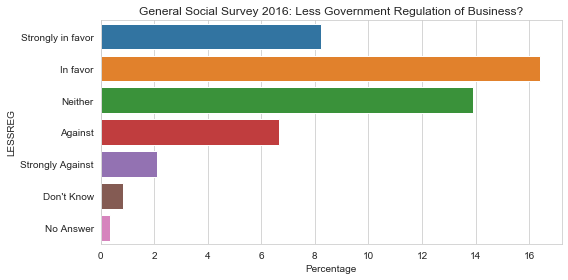

In [2]:
df2016 = pd.read_csv(r'C:\MyFiles\OneDrive\NORTHWESTERN\gss\gss2016.csv')
reg = df2016.query('LESSREG > 0')
reg = reg.groupby('LESSREG')['MAR1'].count().apply(lambda x: (x*100)/2867).reset_index()
reg.columns = ['LESSREG','Percentage']


def regvals(x):
    
    
    if x == 1: return "Strongly in favor"
    if x == 2: return "In favor"
    if x == 3: return "Neither"
    if x == 4: return "Against"
    if x == 5: return "Strongly Against"
    if x == 8: return "Don't Know"
    if x == 9: return "No Answer"
    else: return x
    

reg['LESSREG'] = reg.LESSREG.apply(regvals)

plt.figure(figsize=(8,4))
sns.set_style('whitegrid')
y_order = ["Strongly in favor","In favor","Neither","Against","Strongly Against","Don't Know","No Answer"]
ax = sns.barplot(y=reg.LESSREG, x = reg.Percentage,order=y_order)
plt.title('General Social Survey 2016: Less Government Regulation of Business?')
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('GSS - Less Government Regulation.png')

### 2016: Corrupt government administrators?

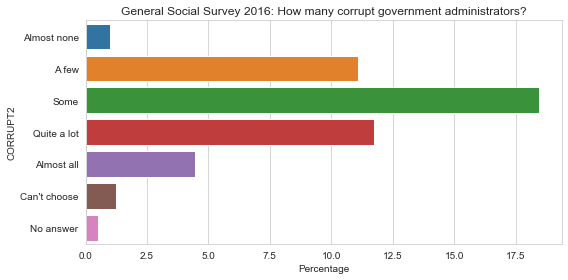

In [3]:
# Read in and clean the data
df2016 = pd.read_csv(r'C:\MyFiles\OneDrive\NORTHWESTERN\gss\gss2016.csv')
cor = df2016.query('CORRUPT2 > 0')
cor = cor.groupby('CORRUPT2')['MAR1'].count().apply(lambda x: (x*100)/2867).reset_index()
cor.columns = ['CORRUPT2','Percentage']

def corvals(x):
    
    
    if x == 1: return "Almost none"
    if x == 2: return "A few"
    if x == 3: return "Some"
    if x == 4: return "Quite a lot"
    if x == 5: return "Almost all"
    if x == 8: return "Can't choose"
    if x == 9: return "No answer"
    else: return x
    

cor['CORRUPT2'] = cor.CORRUPT2.apply(corvals)

# Create the Bar Chart
plt.figure(figsize=(8,4))
y_order = ["Almost none","A few","Some","Quite a lot","Almost all","Can't choose","No answer"]
ax = sns.barplot(x=cor.Percentage,y = cor.CORRUPT2,order=y_order)
plt.title('General Social Survey 2016: How many corrupt government administrators?')
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('GSS - Corrupt Government Administrators.png')

# Logistic Regression
## Political Beliefs, Administrative Corruption, and Government Regulation

In [2]:
df2016 = pd.read_csv(r'C:\MyFiles\OneDrive\NORTHWESTERN\gss\gss2016.csv')
df = df2016
df = df.loc[:,('PARTYID','LESSREG','CORRUPT2')]

# Clean the data

# Clean the target variable PARTYID:
def party(x):
    dem = [0,1,2]
    if x in dem: return "Democrat"
    rep = [4,5,6]
    if x in rep: return "Republican"
    else: return x
    
df['Party'] = df.PARTYID.apply(party)
df = df.query('Party == "Democrat" or Party == "Republican"')
party_dums = pd.get_dummies(df.Party,drop_first=True) # Republican = 1
df = pd.concat([df,party_dums],axis=1)

# Clean Regulation Variable

def regfunc(x):
    
    for_reg = [1,2]
    if x in for_reg: return "For_Less_Regulation"
    against_reg = [4,5]
    if x in against_reg: return "Against_Less_Regulation"
    else: return x
    
df['Regulation'] = df.LESSREG.apply(regfunc)
df = df.query('Regulation == "For_Less_Regulation" or Regulation == "Against_Less_Regulation"')
reg_dums = pd.get_dummies(df.Regulation,drop_first=True) # Republican = 1
df = pd.concat([df,reg_dums],axis=1)

# Clean Corrupt Administrators Variable
# Corrupt Administrators is an ordinal variable, so we will need to create dummies for each level

# Identify only the declarative answers
df = df[df['CORRUPT2'].isin([1,2,3,4,5])]

# Recode the answers from their code to response
def corvals(x):
    
    if x == 1: return "Almost none"
    if x == 2: return "A few"
    if x == 3: return "Some"
    if x == 4: return "Quite a lot"
    if x == 5: return "Almost all"
    else: return x

# Apply the function to recode the variables
df['Corrupt_Admin'] = df.CORRUPT2.apply(corvals)

# Create dummy variables for the corruption belief levels
cor_dums = pd.get_dummies(df.Corrupt_Admin,drop_first=True)
df = pd.concat([df,cor_dums],axis=1)
df.head()

,PARTYID,LESSREG,CORRUPT2,Party,Republican,Regulation,For_Less_Regulation,Corrupt_Admin,Almost all,Almost none,Quite a lot,Some
1,2,1,3,Democrat,0,For_Less_Regulation,1,Some,0,0,0,1
3,5,2,5,Republican,1,For_Less_Regulation,1,Almost all,1,0,0,0
5,1,4,4,Democrat,0,Against_Less_Regulation,0,Quite a lot,0,0,1,0
6,5,1,4,Republican,1,For_Less_Regulation,1,Quite a lot,0,0,1,0
8,0,2,2,Democrat,0,For_Less_Regulation,1,A few,0,0,0,0


# Logistic Regression

In [5]:
import statsmodels.api as sm

# Specify the Independent and Dependent Variables
# Independent Variables
features = df[['Republican','Almost all','Almost none','Quite a lot','Some']]
# Dependent Variable
target = df['For_Less_Regulation']


logit = sm.Logit(target, features)

# fit the model
result = logit.fit()

print(result.summary())
print('\n')
print('Log Odds likelihoods of Independent variables')
print(np.exp(result.params))

Optimization terminated successfully.
         Current function value: 2.630742
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     For_Less_Regulation   No. Observations:                  775
Model:                           Logit   Df Residuals:                      770
Method:                            MLE   Df Model:                            4
Date:                 Sun, 17 Nov 2019   Pseudo R-squ.:                     inf
Time:                         12:04:26   Log-Likelihood:                -2038.8
converged:                        True   LL-Null:                        0.0000
Covariance Type:             nonrobust   LLR p-value:                     1.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Republican      1.8012      0.187      9.609      0.000       1.434       2.169
Almost all      0.

C:\Users\richa\Anaconda3\envs\Statistics\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\richa\Anaconda3\envs\Statistics\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\richa\Anaconda3\envs\Statistics\lib\site-packages\statsmodels\discrete\discrete_model.py:3390: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


## Machine Learning
- Logistic Regression
- Decision Tree Classifier

### Logistic Regression

In [9]:
# split the data
from sklearn.model_selection import train_test_split
X = features
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# train the logistic regression model
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(solver='saga')
logmodel.fit(X_train, y_train)

# print the coefficients of the log model
coefs = logmodel.coef_.reshape(5,1)
print('Logit Model Coefficients')
print(pd.DataFrame(coefs,X.columns,columns=['Coefficients']))
print('\n')

# predict support for less government regulation 
predictions = logmodel.predict(X_test)

# print classification report and confusion matrix
from sklearn.metrics import classification_report
print('Classification Report')
print(classification_report(y_test,predictions))
print('\n')

from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_test, predictions))

Logit Model Coefficients
             Coefficients
Republican       1.375628
Almost all       0.011787
Almost none     -0.608855
Quite a lot      0.355379
Some             0.029299


Classification Report
              precision    recall  f1-score   support

           0       0.50      0.03      0.05        76
           1       0.71      0.99      0.82       180

    accuracy                           0.70       256
   macro avg       0.60      0.51      0.44       256
weighted avg       0.65      0.70      0.59       256



Confusion Matrix
[[  2  74]
 [  2 178]]


In [10]:
#            Predicted No |  Predicted Yes
# Actual No |_____________|__________________
# Actual Yes|_____________|__________________

### Decision Tree Classifier

In [7]:
from sklearn.tree import DecisionTreeClassifier
features = df[['Republican','Almost all','Almost none','Quite a lot','Some']]
# Dependent Variable
target = df['For_Less_Regulation']

from sklearn.model_selection import train_test_split
X = features
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Instantiate the model
dtree = DecisionTreeClassifier()

# Fit the model to training data 
dtree.fit(X_train,y_train)

# Predict support for less government regulation
dtree_pred = dtree.predict(X_test)

from sklearn.metrics import classification_report
print('Classification Report')
print(classification_report(y_test,dtree_pred))
print('\n')

from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_test, dtree_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.03      0.05        76
           1       0.71      0.99      0.82       180

    accuracy                           0.70       256
   macro avg       0.60      0.51      0.44       256
weighted avg       0.65      0.70      0.59       256



Confusion Matrix
[[  2  74]
 [  2 178]]


### Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier

features = df[['Republican','Almost all','Almost none','Quite a lot','Some']]
# Dependent Variable
target = df['For_Less_Regulation']

from sklearn.model_selection import train_test_split
X = features
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


rfc = RandomForestClassifier(n_estimators=50)

rfc.fit(X_train,y_train)

rfc_pred = rfc.predict(X_test)

print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred))

[[  2  74]
 [  2 178]]


              precision    recall  f1-score   support

           0       0.50      0.03      0.05        76
           1       0.71      0.99      0.82       180

    accuracy                           0.70       256
   macro avg       0.60      0.51      0.44       256
weighted avg       0.65      0.70      0.59       256

